OCNG 669 project by Aditya Chakravarty [UIN 624005036] Date: 29 April 2021

**Title : Unsupervised clustering of fracturing-induced microearthquake signals**

The raw data used in this project is available in public domain and can be accessed from : https://gdr.openei.org/submissions/1166

In [49]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle
import matplotlib.ticker as plticker
import matplotlib.dates as mdates
from matplotlib import ticker, colors
import matplotlib.dates as dates
import umap
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
import math
from obspy import UTCDateTime
import seaborn as sns
from IPython.display import Image
file_folder='/home/aditya/Desktop/vbox_h5'
os.chdir(file_folder) 

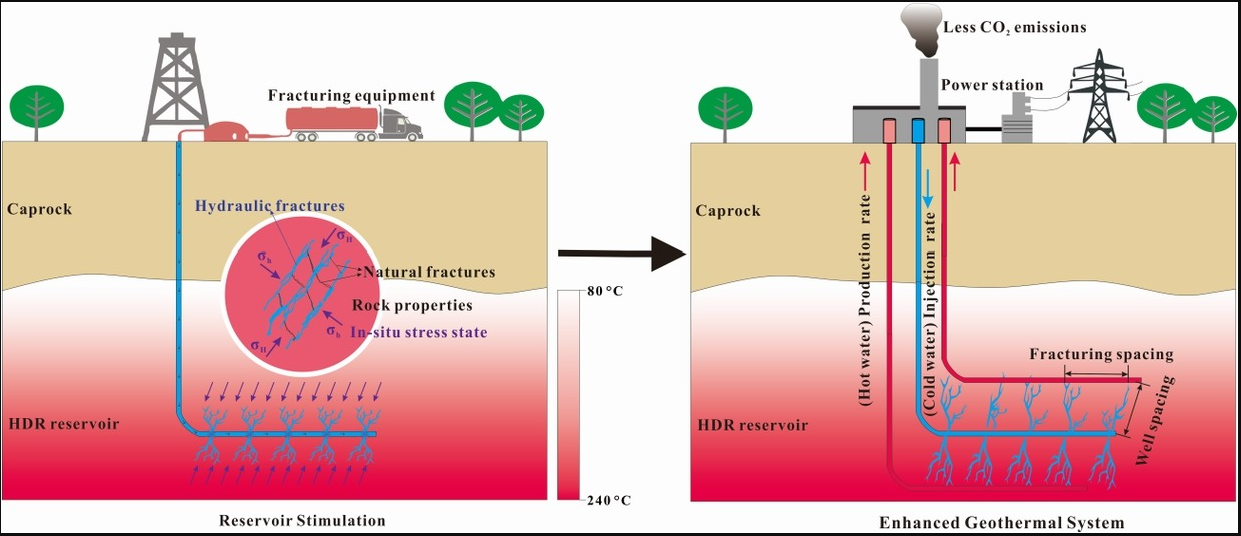

In [53]:
Image("context.png")
# schematic of hydraulic fracturing and enhanced geothermal systems, similarities and differences are highlighted


Reference : Lei, Z., Zhang, Y., Zhang, S., Fu, L., Hu, Z., Yu, Z., Li, L., & Zhou, J. (2020). Electricity generation from a three-horizontal-well enhanced geothermal system in the Qiabuqia geothermal field, China: Slickwater fracturing treatments for different reservoir scenarios. Renewable Energy, 145, 65–83. https://doi.org/10.1016/j.renene.2019.06.024

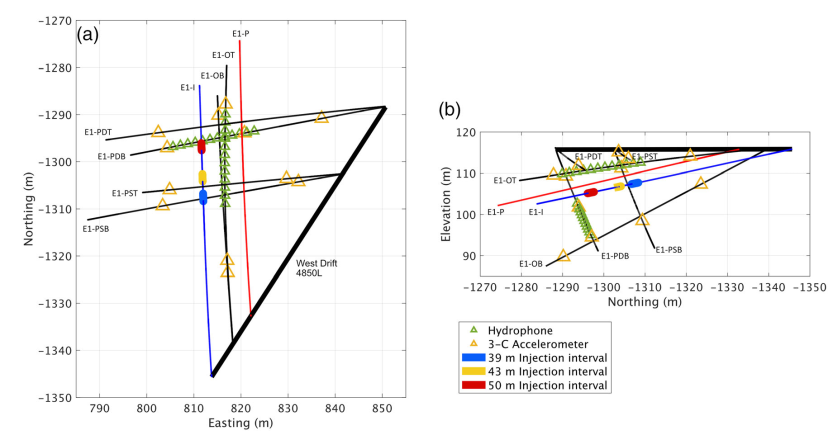

In [55]:
Image('setup.png')

# Schematic of the experimental setup of the EGS collab project experiment 1 testbed. It is located in Leads,
# South Dakota at a depth of 1.5 km in an abandoned gold mine. 

Reference: Schoenball, M., Ajo‐Franklin, J. B., Blankenship, D., Chai, C., **Chakravarty, A.** , Dobson, P., Hopp, C., Kneafsey, T., Knox, H. A., Maceira, M., Robertson, M. C., Sprinkle, P., Strickland, C., Templeton, D., Schwering, P. C., Ulrich, C., & Wood, T. (2020). Creation of a Mixed‐Mode Fracture Network at Mesoscale Through Hydraulic Fracturing and Shear Stimulation. Journal of Geophysical Research: Solid Earth, 125(12), e2020JB019807. https://doi.org/10.1029/2020JB019807

Figure below shows X component data of three component accelerometers to show differences in ground motion sensitivity

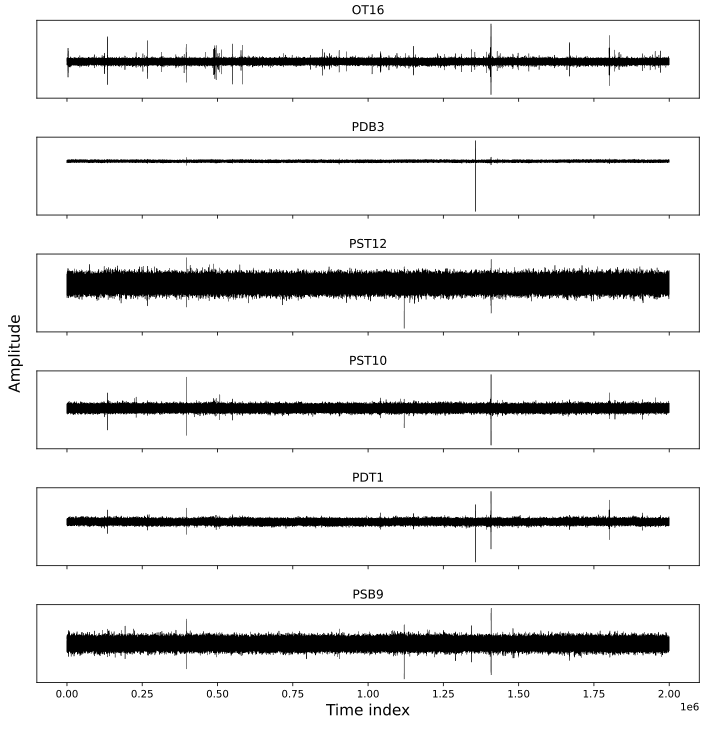

In [57]:
Image('traces.png')

As it is clear from above image, not all the accelerometers (the sensors used to detect particle motion) have the same sensitivity to ground motion. In this project I consider the data from only single accelerometer (OT16) on a single experiment, conducted on 22 May 2018. 

From the continuous recording of OT16 accelerometer, the impulsive earthquake signals are filtered out in form of uniformly sized, discrete time intervals. These have been saved as traces into a pickled file. 

In [2]:
# load relevant data from pickled files-

with open('event_params_22_full.pkl', 'rb') as f:
    event_params = pickle.load(f)
    
with open('tr_list.pkl', 'rb') as f:
    tr_data = pickle.load(f)
    
with open('timelist.pkl', 'rb') as f:
    timelist = pickle.load(f)

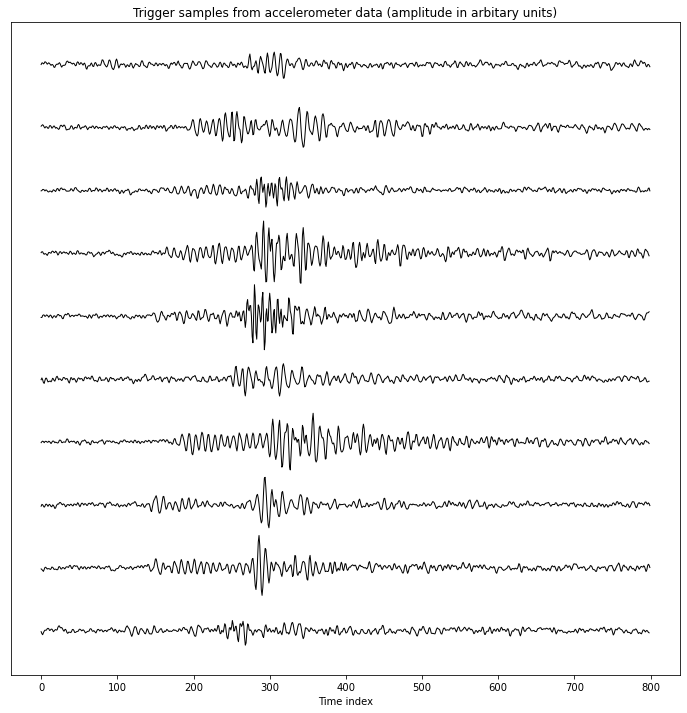

In [58]:
# show an example of waveforms of microearthquake triggers

fig = plt.figure(figsize=(12,12)) 
for i in range(80,90):
    plt.plot(tr_data[i][0] + 0.004*i, 'k', linewidth =1)
    
plt.xlabel('Time index')
ax = plt.gca()
plt.title('Trigger samples from accelerometer data (amplitude in arbitary units)')
ax.axes.yaxis.set_visible(False)


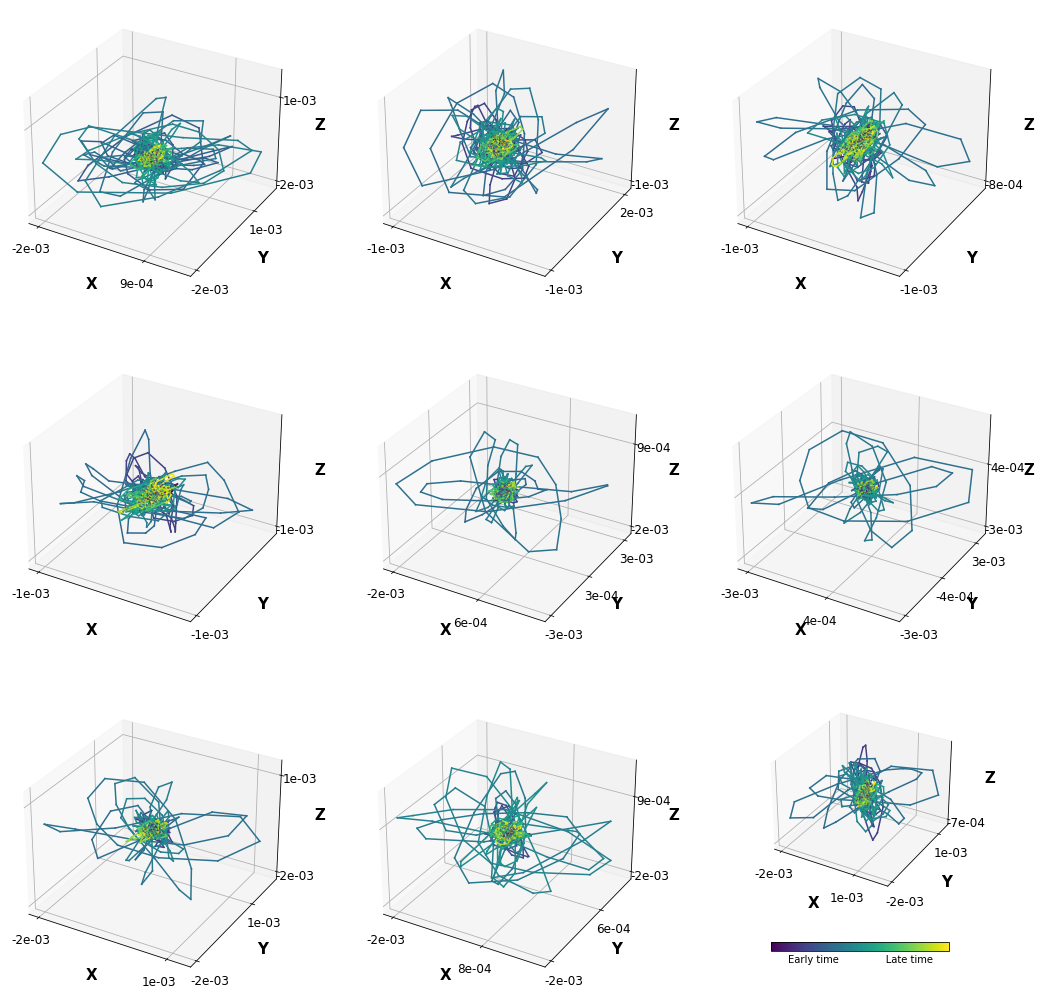

In [4]:
# show an example of the data under study, plot the three dimensional particle trajectory
# in the signal

   
select_rows = event_params.loc[event_params['label'] ==2]
sampled = select_rows.sample(n = 9) 
sampled = sampled.reset_index(drop = False)
sampled['index'].values
N = len(tr_data[0][0])

fig = plt.figure(figsize=(18,18))

for j in range(1,10):
    ax1 = fig.add_subplot(3, 3, j, projection='3d')
    
    y = tr_data[sampled['index'].values[j-1]][0]
    x = tr_data[sampled['index'].values[j-1]][1]
    z = tr_data[sampled['index'].values[j-1]][2]
    c = np.linspace(0,1, len(tr_data[sampled['index'].values[j-1]][0]))
    
    cn = colors.Normalize(min(c), max(c)) # creates a Normalize object for these z values
    
    for i in range(N-1):
        p= ax1.scatter(x[i:i+2], y[i:i+2], z[i:i+2], color=plt.cm.viridis(cn(c[i])), s=0.1)
        q= ax1.plot(x[i:i+2], y[i:i+2], z[i:i+2], color=plt.cm.viridis(cn(c[i])))   
        
    ax1.set_xlabel('X', size = 15 ,fontweight='bold')
    ax1.set_ylabel('Y', size = 15,fontweight='bold')
    ax1.set_zlabel('Z', size = 15,fontweight='bold')  
    
    ticks = np.arange(np.min(x), np.max(x), 0.003)
    ax1.set_xticks(ticks)
    ax1.set_xticklabels(ticks, fontsize=12)  
    ticks = np.arange(np.min(y), np.max(y), 0.003)
    ax1.set_yticks(ticks)
    ax1.set_yticklabels(ticks, fontsize=12) 
    ticks = np.arange(np.min(z), np.max(z), 0.003)
    ax1.set_zticks(ticks)
    ax1.set_zticklabels(ticks, fontsize=12) 
    
    ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
    ax1.zaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))

cbar = fig.colorbar(p, ax = ax1, shrink=0.6, 
                    ticks=[ np.min(dates.date2num(event_params['Time'].values)),
                            np.max(dates.date2num(event_params['Time'].values))],
                   orientation='horizontal',
             label='Early time               Late time')

fig.suptitle('Three dimensional particle trajectory')


In [5]:
# define polarization features and their calculations...

def flinn(y):
    """
    Computes the azimuth, incidence, rectilinearity and planarity after the
    eigenstructure decomposition method of [Flinn1965b].
    :returns:  azimuth, incidence, rectilinearity, and planarity
    """  
    x = np.zeros((3,len(y[0])), dtype=np.float64)
    
    x[0, :] = y[2]
    x[1, :] = y[1]
    x[2, :] = y[0]

    covmat = np.cov(x)
    eigvec, eigenval, v = np.linalg.svd(covmat)
    # Rectilinearity defined after Montalbetti & Kanasewich, 1970
    rect = 1.0 - np.sqrt(eigenval[1] / eigenval[0])
    # Planarity defined after [Jurkevics1988]_
    plan = 1.0 - (2.0 * eigenval[2] / (eigenval[1] + eigenval[0]))
    azimuth = math.degrees(math.atan2(eigvec[0][0], eigvec[1][0]))
    eve = np.sqrt(eigvec[0][0] ** 2 + eigvec[1][0] ** 2)
    incidence = math.degrees(math.atan2(eve, eigvec[2][0]))
    if azimuth < 0.0:
        azimuth = 360.0 + azimuth
    if incidence < 0.0:
        incidence += 180.0
    if incidence > 90.0:
        incidence = 180.0 - incidence
        if azimuth > 180.0:
            azimuth -= 180.0
        else:
            azimuth += 180.0
    if azimuth > 180.0:
        azimuth -= 180.0

    return azimuth, incidence, rect, plan

In [7]:
featlist = []
for i in range(len(tr_data)):
    y = tr_data[i]
    flinn_fts = flinn(y) # azimuth, incidence, rectilinearity and planarity                  
    featlist.append(flinn_fts)

In [8]:
feat_list = pd.DataFrame(featlist)    
feat_list.columns = ['azimuth','incidence','rectilinearity','planarity']
feat_list

,azimuth,incidence,rectilinearity,planarity
0,41.778466,58.123624,0.837814,0.955561
1,42.001267,60.149591,0.832388,0.951279
2,136.946028,62.278107,0.202991,0.641733
3,41.921259,58.302205,0.777548,0.920165
4,41.130615,59.361369,0.863806,0.967858
...,...,...,...,...
810,11.868326,50.539388,0.448166,0.743140
811,2.314170,48.573568,0.383898,0.725695
812,1.905253,41.524011,0.289761,0.700207
813,10.091359,38.928799,0.378629,0.774311


In [9]:
# scaling the variables for dimension reduction, 
# using minmax scaler since variables are bound within 0-180 and 0-1. 

scaler = MinMaxScaler()
scaled = scaler.fit_transform(feat_list)

In [10]:
# dimension reduction using manifold projection, the method I have used is Uniform manifold approximation 
# projection (UMAP)

reducer = umap.UMAP(n_neighbors=8 , min_dist= 0.001, 
                    metric = 'euclidean', n_components=2, random_state=42)
embedding = reducer.fit_transform(scaled)



Text(0.5, 1.0, 'UMAP projection of the data')

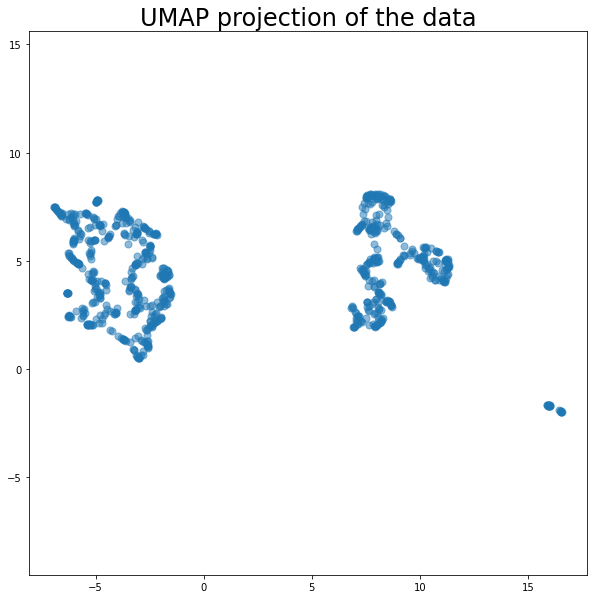

In [11]:
# plot the embeddings in UMAP space-

fig = plt.figure(figsize=(10,10))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1], alpha = 0.5, s= 50)  #--color on UMAP space based on time---
plt.gca().set_aspect('equal', 'datalim')

plt.title('UMAP projection of the data', fontsize=24)

Estimated number of clusters: 5
Estimated number of noise points: 17


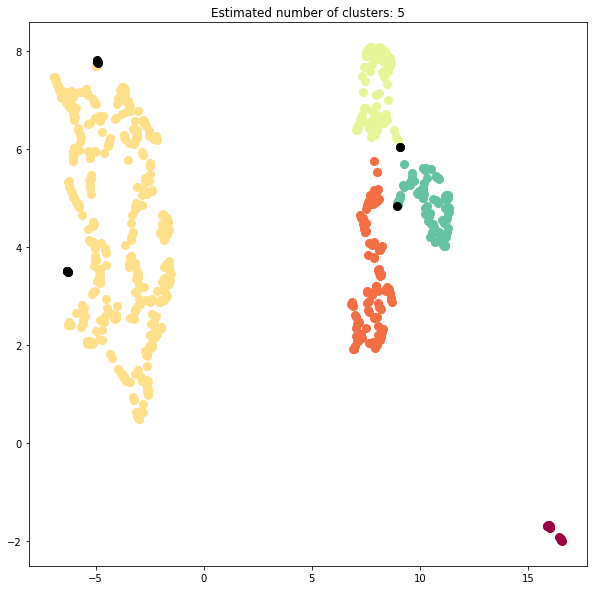

In [12]:
# obtain cluster labels using DBSCAN algorithm

from sklearn.cluster import DBSCAN   
# Compute DBSCAN
db = DBSCAN(eps=0.705, min_samples=20).fit(embedding)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
labels_dbscan = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

# #############################################################################
# Plot result
# Black removed and is used for noise instead.

fig = plt.figure(figsize=(10,10))

unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
    class_member_mask = (labels == k)
    xy = embedding[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1],'o', c=tuple(col),
             markersize=8)
    xy = embedding[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1],'o', c=tuple(col),
             markersize=8)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()


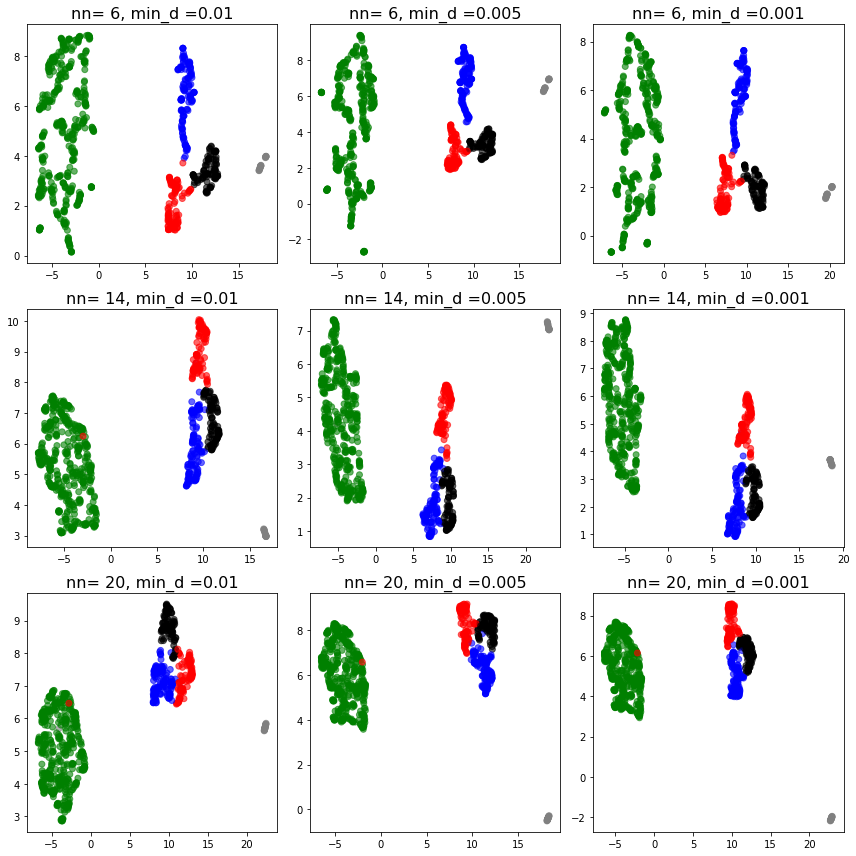

In [13]:
# I vary the two key hyperparameters in UMAP : number of neighbors and minimum distance 
# over one order of magnitude to show that UMAP distribution is largely unchanged by 
#  small variations in hyperparameters 

nneigh_list  = [6 ,14, 20]
mind_list = [0.01, 0.005, 0.001]
nclist = [2,3, 4]
ncomp = nclist[1]

col_list = [ 'grey', 'b', 'g', 'r', 'k']
colors = [col_list[i+1] for i in event_params['label']]

fig = plt.figure(figsize=(12,12))

for i in range(len(nneigh_list)):
    for j in range(len(mind_list)):
        reducer = umap.UMAP(n_neighbors=nneigh_list[i], min_dist= mind_list[j], 
                    metric = 'euclidean', n_components=2, random_state=42)
        embedding = reducer.fit_transform(scaled)
        ax1 = fig.add_subplot(len(nneigh_list), len(mind_list), 3*i+j+1)
        ax1.scatter(embedding[:, 0], embedding[:, 1],c = colors, alpha = 0.6)      
        ax1.set_title(str('nn= '+ str(nneigh_list[i]) +', min_d =' + str(mind_list[j])), fontsize=16)

plt.tight_layout() 

In [14]:
# find out which of the triggers actually correspond to located events 

file_folder='/home/aditya/Desktop/vbox_h5'
os.chdir(file_folder)

event_info = pd.read_excel('catalog_v190312_faults.xlsx')

mask = (event_info['date'] > timelist[0]) & (event_info['date'] <= timelist[-1]) 

rows = event_info.loc[mask]
rows=rows.reset_index(drop=True)

idx_known = [] # all events including undesignated events
for i in range(len(rows)):
    t_samp = UTCDateTime(rows['date'][i])
    idx = min(range(len(timelist)), key=lambda i: abs(UTCDateTime(timelist[i])-t_samp)) # find the nearest index
    idx_known.append(idx)
    

In [15]:
'''load hydraulic data data'''

hyd_data = pd.read_csv('hyd_data.csv')

# begin with 22 may data------------------

mask = (pd.to_datetime(hyd_data['Time'], utc = True) > pd.to_datetime(event_params['Time'].iloc[0])) & (pd.to_datetime(hyd_data['Time'], utc = True) <= pd.to_datetime(event_params['Time'].iloc[-1]))

hyd_rows = hyd_data.loc[mask]
hyd_rows=hyd_rows.reset_index(drop=False)

Text(0.5, 0, 'Time')

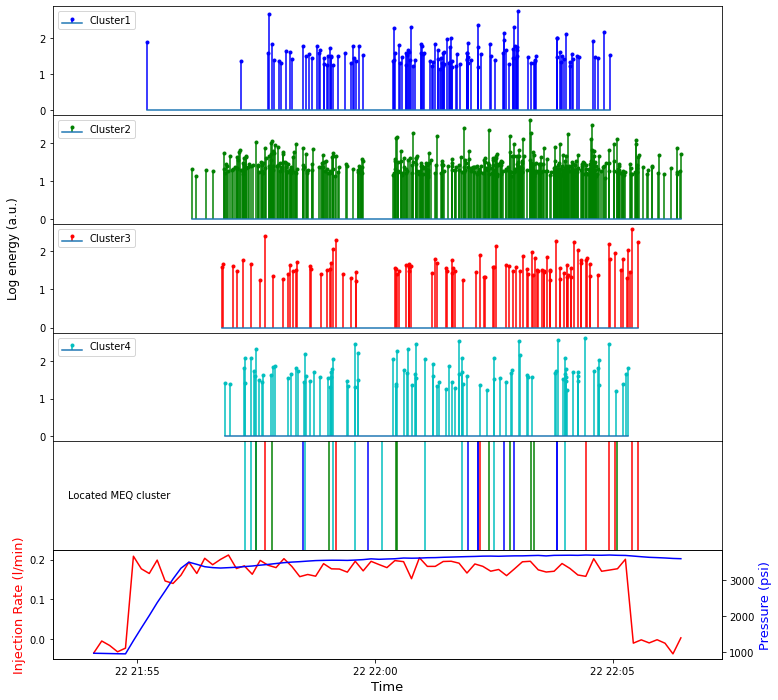

In [98]:
col_list = ['b','g','r', 'c']
mkr_list = ['b.','g.','r.','c.']
label_list = [0,1,2,3]
clist = ['Cluster1','Cluster2','Cluster3','Cluster4']

loc = plticker.MultipleLocator(base=1.0)

fig, axs = plt.subplots(nrows=len(label_list)+2, ncols=1, sharex=(True), sharey=(False), figsize = (12, 12))
fig.subplots_adjust(hspace=0)
for i in range(len(col_list)):

    event_params_select = event_params.loc[event_params['label'] == label_list[i]]
    event_params_select=event_params_select.reset_index(drop=False) 
    ene = np.log10(event_params_select['en'].values * 10e5)
    #ene = [np.sum(tr_data[event_params_select['index'].values[i]]**2) for i in range(len(event_params_select))]

    
    axs[i].stem(pd.to_datetime(event_params_select['Time']),ene,col_list[i],
                markerfmt=mkr_list[i],  basefmt = "", label = clist[i])
    axs[i].set_xlim(pd.to_datetime(event_params['Time'][0])- pd.Timedelta(seconds = 50), 
         pd.to_datetime(event_params['Time'].values[-1]) + pd.Timedelta(seconds = 50)) 
    # axs[i].set_ylim(0, np.max(np.log10(event_params['en'].values * 10e5)))
    axs[i].legend(loc="upper left")
    axs[i].xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
    axs[i].set_xlabel('Time')
    #axs[i].set_ylabel('Log energy (a.u.)')
fig.text(.08, .6, 'Log energy (a.u.)', ha='center', va='center', rotation='vertical', size = 12)

colorlist = [col_list[i] for i in event_params['label'].iloc[idx_known].values]

for i in range(len(colorlist)): 
    axs[4].axvline(pd.to_datetime(rows['date'])[i], c= colorlist[i], linewidth = 1.5) 
    
axs[4].text(0.1, 0.5, 'Located MEQ cluster', horizontalalignment='center', verticalalignment='center', transform=axs[4].transAxes)
axs[4].axes.yaxis.set_visible(False)

axs[5].plot( pd.to_datetime(hyd_rows['Time']),hyd_rows.iloc[:,3] + hyd_rows.iloc[:,5], label = 'Injection_rate', c= 'r')
ax_twin = axs[5].twinx()
axs[5].set_ylabel('Injection Rate (l/min)', c= 'r', size = 13)
ax_twin.plot(pd.to_datetime(hyd_rows['Time']), hyd_rows.iloc[:,28],  label = 'Pressure', c= 'b' )
ax_twin.set_ylabel('Pressure (psi)', c= 'b', size = 13)
axs[5].set_xlim(pd.to_datetime(event_params['Time'][0])- pd.Timedelta(seconds = 50), 
     pd.to_datetime(event_params['Time'].values[-1]) + pd.Timedelta(seconds = 50)) 
axs[5].set_xlabel('Time', size = 13) 

In [24]:
fts_with_labels = pd.concat([feat_list, pd.DataFrame(labels)], axis = 1)
fts_with_labels.columns.values[4] = "label"
fts_with_labels

,azimuth,incidence,rectilinearity,planarity,label
0,41.778466,58.123624,0.837814,0.955561,0
1,42.001267,60.149591,0.832388,0.951279,0
2,136.946028,62.278107,0.202991,0.641733,1
3,41.921259,58.302205,0.777548,0.920165,0
4,41.130615,59.361369,0.863806,0.967858,0
...,...,...,...,...,...
810,11.868326,50.539388,0.448166,0.743140,2
811,2.314170,48.573568,0.383898,0.725695,2
812,1.905253,41.524011,0.289761,0.700207,2
813,10.091359,38.928799,0.378629,0.774311,-1


<Figure size 936x936 with 0 Axes>

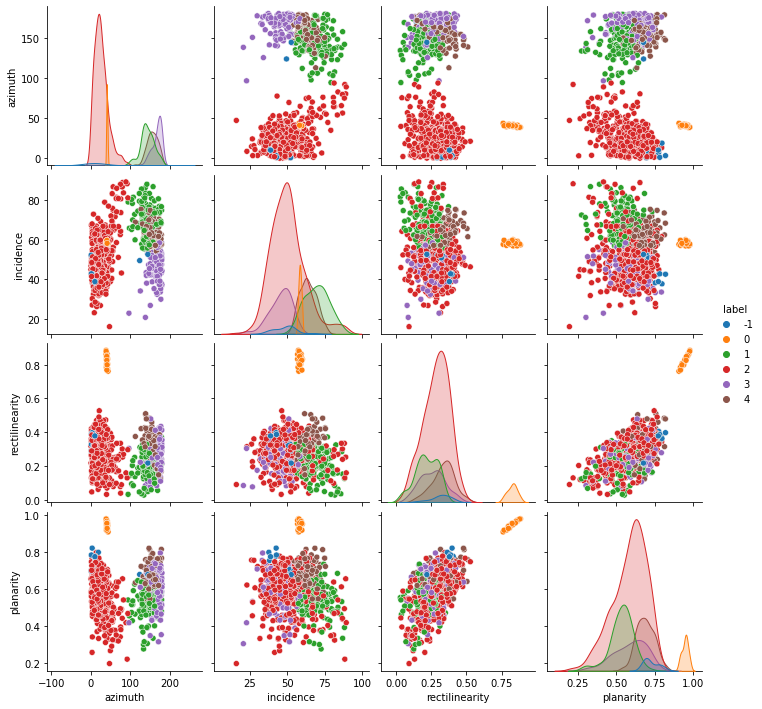

In [60]:
# show pairplot to show relationship between variables and assigned clusters
fig = plt.figure(figsize=(13,13))
sns.pairplot(fts_with_labels, hue="label", palette = "tab10")

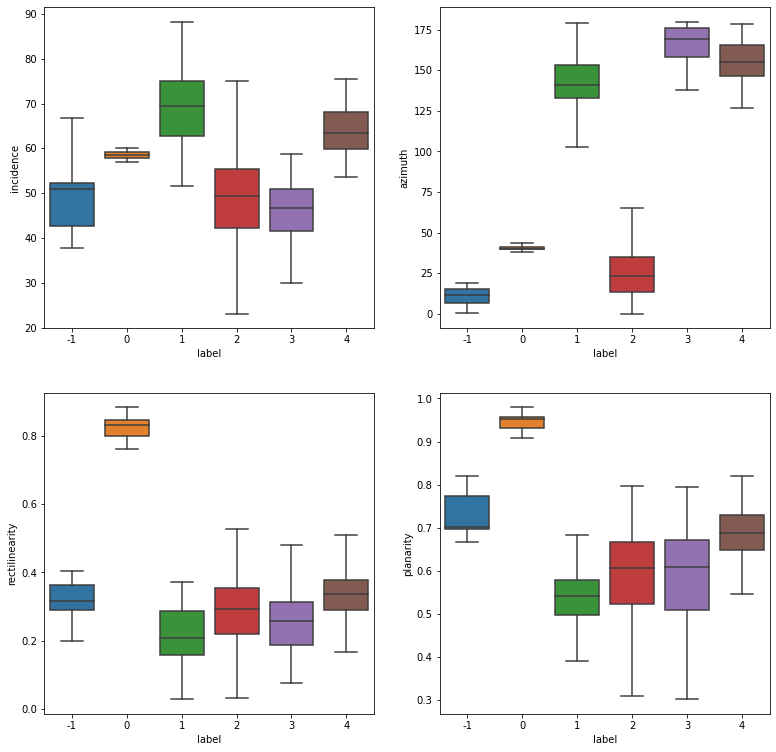

In [46]:
# show boxplot to show how the the quartiles of data are varying over the clusters----
fig = plt.figure(figsize=(13,13))

axs = fig.add_subplot(2, 2, 1)    
axs = sns.boxplot(x="label", y="incidence", data=fts_with_labels, showfliers = False)

axs = fig.add_subplot(2, 2, 2)    
axs = sns.boxplot(x="label", y="azimuth", data=fts_with_labels, showfliers = False)

axs = fig.add_subplot(2, 2, 3)    
axs = sns.boxplot(x="label", y="rectilinearity", data=fts_with_labels, showfliers = False)

axs = fig.add_subplot(2, 2, 4)    
axs = sns.boxplot(x="label", y="planarity", data=fts_with_labels, showfliers = False)

Play an animation of the located events in space and time colored by cluster labels.

In [16]:
import io
from IPython.display import HTML
import base64

In [17]:
video = io.open('/home/aditya/Desktop/vbox_h5/trial.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
<video controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
</video>'''.format(encoded.decode('ascii')))